### Preprocessing steps

1) Cropping 
2) Turn the image into black and white
3) Histogram
4) Threshold
5) Binarize

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import radon, iradon, rescale
from ipywidgets import interact, IntSlider
import time

In [2]:
def load_images_from_folder(folder):
    images = {}
    keys = []
    for filename in os.listdir(folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # extensões de imagem
            keys.append(filename[:-4]) #Para eliminar os 4 ultimos caracteres, ou a extensao.
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.convert('L') #Converte a imagem para escala de cinza
            img_variable_name = os.path.splitext(filename)[0]
            images[img_variable_name] = img
    return images, keys

In [3]:
def plot(img,title,histogram = False):
    
    #plot
    plt.figure(figsize=(7,5)) # Define figure size - default size is quite small.
    plt.imshow(img, cmap='gray') # cmap is used to choose the colormap
    plt.title(title) # Title of the image
    plt.colorbar(label='Intensity (HU)') # Display a colorbar with label
    plt.axis("off") # Turn off the axis ticks and labels 
    plt.show()

    
    if isinstance(img, np.ndarray):
        #info
        print(f'Size: {img.shape}')
        pixels = list(img.flatten())
        print(f'Tipo de imagem: {type(img)}')
        print(f'Tom de cinza mínimo: {img.min()}')
        print(f'Tom de cinza máximo: {img.max()}')

    else:    
        #info
        print(f'Size: {img.size}')
        print(f'Tipo de imagem: {type(img)}')
        pixels = list(img.getdata())
        min_gray = min(pixels)
        max_gray = max(pixels)
        print(f'Tom de cinza mínimo: {min_gray}')
        print(f'Tom de cinza máximo: {max_gray}\n')

        
    if histogram == True:
        #histogram
        histogram = [0] * 256
        for pixel in pixels:
            histogram[pixel] += 1
        plt.figure(figsize=(10, 5))
        plt.bar(range(256), histogram, width=1, color='black')
        plt.title('Histograma da Imagem Recortada (Cropped)')
        plt.xlabel('Valor de Intensidade de Cinza')
        plt.ylabel('Frequência')
        plt.grid(axis='y')
        plt.show()
    return pixels

In [4]:
def crop_image(image):
    left = 850
    top = 650
    right = 1800
    bottom = 1600
    return image.crop((left, top, right, bottom))

def stacking(images_dict, keys): 
    
    ## Funções:
    ### Carregar as imagens a partir dos input de um dicionario e suas chaves, correspondendo as fotos retiradas 
        ### sob diferentes angulos
    ### Recortar a imagem, utilizando a função "crop_image"
    ### Empilhar os dados em um array numpy
    
    data = []
    for filename in keys:
        img = images_dict[filename]
        crop_img = crop_image(img)
        #mask = LUT(crop_img, 175, 255,False)
        data.append(crop_img)
        print(f'File {filename} successfully appended')
    data_3d = np.stack(data,axis=2)     
    return data_3d



In [33]:
def iRadonT(sinogram,theta,plot = False):
    reconstruction_ufbp = iradon(sinogram, theta=theta, filter_name=None,  circle=True);

    if plot == True:    
        plt.figure(figsize=(8, 8))
        plt.title("Reconstrução do Sinograma")
        plt.imshow(reconstruction_ufbp, cmap='gray', extent=(0, sinogram.shape[0], 0, sinogram.shape[0]), aspect='auto')
        plt.tight_layout()
        plt.show()
        
        print(f'segment.shape = {reconstruction_ufbp.shape}\n')
        
        print(f"We have {len(theta)} angle values.")
        print(f"\nFirst five values of theta:\n{np.around(theta[0:5],3)}")
        print(f"\nLast five values of theta:\n{np.around(theta[-5:],3)}")

    return reconstruction_ufbp
 
def get_nth_line_from_images(stacked_data, n):
    # Lista para armazenar as linhas extraídas
    lines = []
    
    #Iterações dentro da matriz de dados
    for i in range(stacked_data.shape[2]):

        # Converter a imagem para um array numpy
        img_array = stacked_data[:,:,i]

        # Verificar se n está dentro dos limites da imagem
        if n < img_array.shape[0]:
            # Extrair a n-ésima linha
            nth_line = img_array[n, :]

            # Adicionar a linha à lista
            lines.append(nth_line)
        else:
            print(f"A imagem tem menos de {n+1} linhas.")

    # Concatenar todas as linhas extraídas em uma matriz numpy
    if lines:
        result_matrix = np.vstack(lines)
    else:
        result_matrix = np.array([])  # Caso não haja linhas para concatenar

    return result_matrix

def create_segment(n, data3d,plot=False):
    
    
    concatenated_matrix = get_nth_line_from_images(data3d , n)
    sinogram = concatenated_matrix.transpose()
    if plot == True:
        plt.figure(figsize=(7,5)) # Define figure size - default size is quite small.
        plt.imshow(sinogram, aspect='auto', cmap='gray',extent =[0, 180, 0, sinogram.shape[0]-1])        
        plt.title(f"Sinograma, Slice {n}") # Title of the image
        plt.colorbar(label='Intensity (HU)') # Display a colorbar with label
        plt.show()
    print(f'sinogram.shape = {sinogram.shape}')
    theta = np.linspace(0., 180., sinogram.shape[1], endpoint=False);
    segment = iRadonT(sinogram, theta,plot);


    return segment


def create_3d_volume(data3d):

    object_3d = []
    for n in range(data3d.shape[0]):
        segment = create_segment(n, data3d)
        object_3d.append(segment)
        print(f'Segment number {n} succesfully appended')
    reconstruction_3d = np.stack(object_3d,axis=2)
    
    return reconstruction_3d

INICIO DA ROTINA

Imagem image_20240730_092958: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80217DC0>
Imagem image_20240730_093002: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA802170D0>
Imagem image_20240730_093006: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80217460>
Imagem image_20240730_093010: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA8019DC70>
Images Stacking
File image_20240730_092958 successfully appended
File image_20240730_093002 successfully appended
File image_20240730_093006 successfully appended
File image_20240730_093010 successfully appended
data3d.shape = (950, 950, 4)


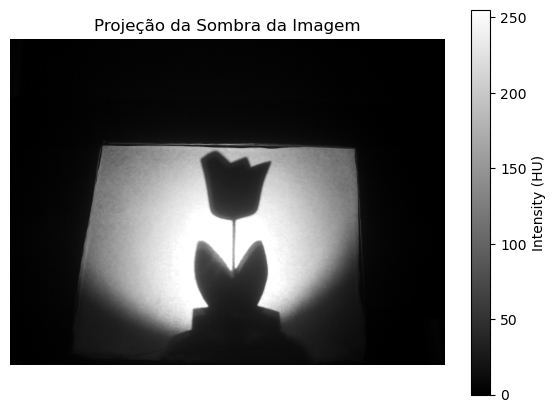

Size: (2592, 1944)
Tipo de imagem: <class 'PIL.Image.Image'>
Tom de cinza mínimo: 0
Tom de cinza máximo: 255



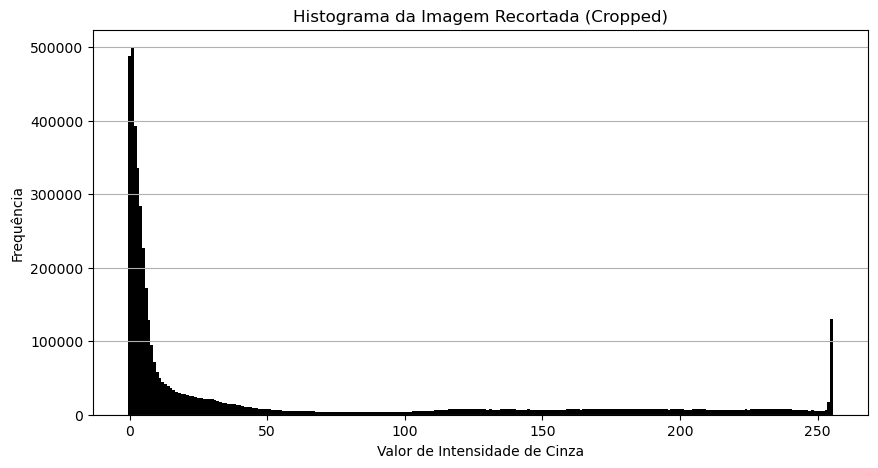

In [39]:
#Verificar Paramtros do Crop

# Carregar as imagens
folder_path = './folder_4ang_20240730_092956/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620

start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

#Image Import
img = images_dict[keys[0]]

plot(img, "Projeção da Sombra da Imagem", True);

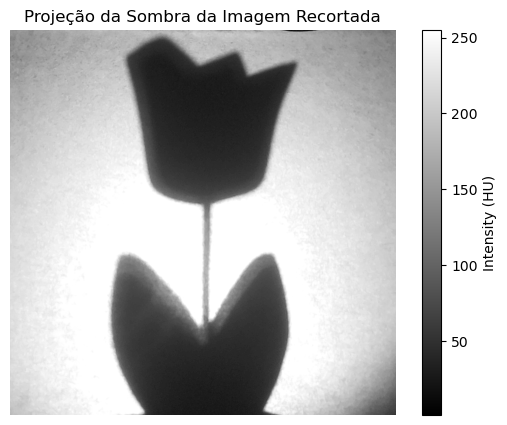

Size: (950, 950)
Tipo de imagem: <class 'PIL.Image.Image'>
Tom de cinza mínimo: 1
Tom de cinza máximo: 255



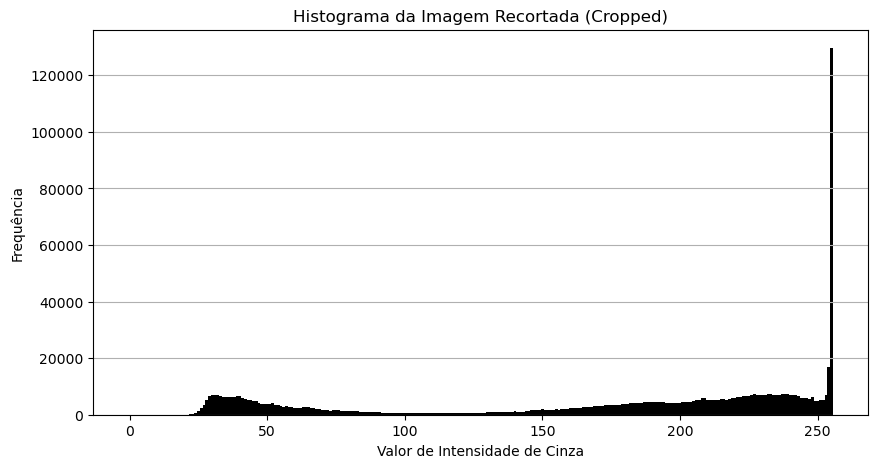

In [38]:
#Crop

crop_img = crop_image(img)

plot(crop_image(img), "Projeção da Sombra da Imagem Recortada",True);

In [8]:
# Carregar as imagens
folder_path = './folder_2ang_20240730_092932/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_2_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_092935: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5E0580>
Imagem image_20240730_092940: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59C6B1B20>
Images Stacking
File image_20240730_092935 successfully appended
File image_20240730_092940 successfully appended
data3d.shape = (950, 950, 2)
Segmentation and 3D Reconstruction
Segment number 0 succesfully appended
Segment number 1 succesfully appended
Segment number 2 succesfully appended
Segment number 3 succesfully appended
Segment number 4 succesfully appended
Segment number 5 succesfully appended
Segment number 6 succesfully appended
Segment number 7 succesfully appended
Segment number 8 succesfully appended
Segment number 9 succesfully appended
Segment number 10 succesfully appended
Segment number 11 succesfully appended
Segment number 12 succesfully appended
Segment number 13 succesfully appended
Segment number 14 succesfully appended
Segment number 15 succesfully appended
Segment number 1

Segment number 203 succesfully appended
Segment number 204 succesfully appended
Segment number 205 succesfully appended
Segment number 206 succesfully appended
Segment number 207 succesfully appended
Segment number 208 succesfully appended
Segment number 209 succesfully appended
Segment number 210 succesfully appended
Segment number 211 succesfully appended
Segment number 212 succesfully appended
Segment number 213 succesfully appended
Segment number 214 succesfully appended
Segment number 215 succesfully appended
Segment number 216 succesfully appended
Segment number 217 succesfully appended
Segment number 218 succesfully appended
Segment number 219 succesfully appended
Segment number 220 succesfully appended
Segment number 221 succesfully appended
Segment number 222 succesfully appended
Segment number 223 succesfully appended
Segment number 224 succesfully appended
Segment number 225 succesfully appended
Segment number 226 succesfully appended
Segment number 227 succesfully appended


Segment number 408 succesfully appended
Segment number 409 succesfully appended
Segment number 410 succesfully appended
Segment number 411 succesfully appended
Segment number 412 succesfully appended
Segment number 413 succesfully appended
Segment number 414 succesfully appended
Segment number 415 succesfully appended
Segment number 416 succesfully appended
Segment number 417 succesfully appended
Segment number 418 succesfully appended
Segment number 419 succesfully appended
Segment number 420 succesfully appended
Segment number 421 succesfully appended
Segment number 422 succesfully appended
Segment number 423 succesfully appended
Segment number 424 succesfully appended
Segment number 425 succesfully appended
Segment number 426 succesfully appended
Segment number 427 succesfully appended
Segment number 428 succesfully appended
Segment number 429 succesfully appended
Segment number 430 succesfully appended
Segment number 431 succesfully appended
Segment number 432 succesfully appended


Segment number 615 succesfully appended
Segment number 616 succesfully appended
Segment number 617 succesfully appended
Segment number 618 succesfully appended
Segment number 619 succesfully appended
Segment number 620 succesfully appended
Segment number 621 succesfully appended
Segment number 622 succesfully appended
Segment number 623 succesfully appended
Segment number 624 succesfully appended
Segment number 625 succesfully appended
Segment number 626 succesfully appended
Segment number 627 succesfully appended
Segment number 628 succesfully appended
Segment number 629 succesfully appended
Segment number 630 succesfully appended
Segment number 631 succesfully appended
Segment number 632 succesfully appended
Segment number 633 succesfully appended
Segment number 634 succesfully appended
Segment number 635 succesfully appended
Segment number 636 succesfully appended
Segment number 637 succesfully appended
Segment number 638 succesfully appended
Segment number 639 succesfully appended


Segment number 820 succesfully appended
Segment number 821 succesfully appended
Segment number 822 succesfully appended
Segment number 823 succesfully appended
Segment number 824 succesfully appended
Segment number 825 succesfully appended
Segment number 826 succesfully appended
Segment number 827 succesfully appended
Segment number 828 succesfully appended
Segment number 829 succesfully appended
Segment number 830 succesfully appended
Segment number 831 succesfully appended
Segment number 832 succesfully appended
Segment number 833 succesfully appended
Segment number 834 succesfully appended
Segment number 835 succesfully appended
Segment number 836 succesfully appended
Segment number 837 succesfully appended
Segment number 838 succesfully appended
Segment number 839 succesfully appended
Segment number 840 succesfully appended
Segment number 841 succesfully appended
Segment number 842 succesfully appended
Segment number 843 succesfully appended
Segment number 844 succesfully appended


In [10]:
# Carregar as imagens
folder_path = './folder_4ang_20240730_092956/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_4_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_092958: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C580021E20>
Imagem image_20240730_093002: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5F1E80>
Imagem image_20240730_093006: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C580021D90>
Imagem image_20240730_093010: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C58002CF70>
Images Stacking
File image_20240730_092958 successfully appended
File image_20240730_093002 successfully appended
File image_20240730_093006 successfully appended
File image_20240730_093010 successfully appended
data3d.shape = (950, 950, 4)
Segmentation and 3D Reconstruction
Segment number 0 succesfully appended
Segment number 1 succesfully appended
Segment number 2 succesfully appended
Segment number 3 succesfully appended
Segment number 4 succesfully appended
Segment number 5 succesfully appended
Segment number 6 succesfully appended
Segment number 7 succesfully appended
Segment number 8 succesfully appended
Segm

Segment number 194 succesfully appended
Segment number 195 succesfully appended
Segment number 196 succesfully appended
Segment number 197 succesfully appended
Segment number 198 succesfully appended
Segment number 199 succesfully appended
Segment number 200 succesfully appended
Segment number 201 succesfully appended
Segment number 202 succesfully appended
Segment number 203 succesfully appended
Segment number 204 succesfully appended
Segment number 205 succesfully appended
Segment number 206 succesfully appended
Segment number 207 succesfully appended
Segment number 208 succesfully appended
Segment number 209 succesfully appended
Segment number 210 succesfully appended
Segment number 211 succesfully appended
Segment number 212 succesfully appended
Segment number 213 succesfully appended
Segment number 214 succesfully appended
Segment number 215 succesfully appended
Segment number 216 succesfully appended
Segment number 217 succesfully appended
Segment number 218 succesfully appended


Segment number 400 succesfully appended
Segment number 401 succesfully appended
Segment number 402 succesfully appended
Segment number 403 succesfully appended
Segment number 404 succesfully appended
Segment number 405 succesfully appended
Segment number 406 succesfully appended
Segment number 407 succesfully appended
Segment number 408 succesfully appended
Segment number 409 succesfully appended
Segment number 410 succesfully appended
Segment number 411 succesfully appended
Segment number 412 succesfully appended
Segment number 413 succesfully appended
Segment number 414 succesfully appended
Segment number 415 succesfully appended
Segment number 416 succesfully appended
Segment number 417 succesfully appended
Segment number 418 succesfully appended
Segment number 419 succesfully appended
Segment number 420 succesfully appended
Segment number 421 succesfully appended
Segment number 422 succesfully appended
Segment number 423 succesfully appended
Segment number 424 succesfully appended


Segment number 605 succesfully appended
Segment number 606 succesfully appended
Segment number 607 succesfully appended
Segment number 608 succesfully appended
Segment number 609 succesfully appended
Segment number 610 succesfully appended
Segment number 611 succesfully appended
Segment number 612 succesfully appended
Segment number 613 succesfully appended
Segment number 614 succesfully appended
Segment number 615 succesfully appended
Segment number 616 succesfully appended
Segment number 617 succesfully appended
Segment number 618 succesfully appended
Segment number 619 succesfully appended
Segment number 620 succesfully appended
Segment number 621 succesfully appended
Segment number 622 succesfully appended
Segment number 623 succesfully appended
Segment number 624 succesfully appended
Segment number 625 succesfully appended
Segment number 626 succesfully appended
Segment number 627 succesfully appended
Segment number 628 succesfully appended
Segment number 629 succesfully appended


Segment number 811 succesfully appended
Segment number 812 succesfully appended
Segment number 813 succesfully appended
Segment number 814 succesfully appended
Segment number 815 succesfully appended
Segment number 816 succesfully appended
Segment number 817 succesfully appended
Segment number 818 succesfully appended
Segment number 819 succesfully appended
Segment number 820 succesfully appended
Segment number 821 succesfully appended
Segment number 822 succesfully appended
Segment number 823 succesfully appended
Segment number 824 succesfully appended
Segment number 825 succesfully appended
Segment number 826 succesfully appended
Segment number 827 succesfully appended
Segment number 828 succesfully appended
Segment number 829 succesfully appended
Segment number 830 succesfully appended
Segment number 831 succesfully appended
Segment number 832 succesfully appended
Segment number 833 succesfully appended
Segment number 834 succesfully appended
Segment number 835 succesfully appended


In [44]:
print("Creating Transverse Plane for 4 angles Reconstruction" )

reconstruction_3d = np.load('reconstruction_3d_4_ang.npy')

# Criar um widget interativo para escolher o índice da imagem
interact(show_image, index=IntSlider(min=0, max=reconstruction_3d.shape[2]-1, step=1, value=0))

Creating Transverse Plane for 4 angles Reconstruction


interactive(children=(IntSlider(value=0, description='index', max=949), Output()), _dom_classes=('widget-inter…

<function __main__.show_image(index)>

In [12]:
# Carregar as imagens
folder_path = './folder_5ang_20240730_093248/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_5_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_093251: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818C2280>
Imagem image_20240730_093255: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8550>
Imagem image_20240730_093258: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D85E0>
Imagem image_20240730_093302: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1F10>
Imagem image_20240730_093306: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C58002C2B0>
Images Stacking
File image_20240730_093251 successfully appended
File image_20240730_093255 successfully appended
File image_20240730_093258 successfully appended
File image_20240730_093302 successfully appended
File image_20240730_093306 successfully appended
data3d.shape = (950, 950, 5)
Segmentation and 3D Reconstruction
Segment number 0 succesfully appended
Segment number 1 succesfully appended
Segment number 2 succesfully appended
Segment number 3 succesfully appended
Segment number 4 succesfully appended
Segment number

Segment number 189 succesfully appended
Segment number 190 succesfully appended
Segment number 191 succesfully appended
Segment number 192 succesfully appended
Segment number 193 succesfully appended
Segment number 194 succesfully appended
Segment number 195 succesfully appended
Segment number 196 succesfully appended
Segment number 197 succesfully appended
Segment number 198 succesfully appended
Segment number 199 succesfully appended
Segment number 200 succesfully appended
Segment number 201 succesfully appended
Segment number 202 succesfully appended
Segment number 203 succesfully appended
Segment number 204 succesfully appended
Segment number 205 succesfully appended
Segment number 206 succesfully appended
Segment number 207 succesfully appended
Segment number 208 succesfully appended
Segment number 209 succesfully appended
Segment number 210 succesfully appended
Segment number 211 succesfully appended
Segment number 212 succesfully appended
Segment number 213 succesfully appended


Segment number 394 succesfully appended
Segment number 395 succesfully appended
Segment number 396 succesfully appended
Segment number 397 succesfully appended
Segment number 398 succesfully appended
Segment number 399 succesfully appended
Segment number 400 succesfully appended
Segment number 401 succesfully appended
Segment number 402 succesfully appended
Segment number 403 succesfully appended
Segment number 404 succesfully appended
Segment number 405 succesfully appended
Segment number 406 succesfully appended
Segment number 407 succesfully appended
Segment number 408 succesfully appended
Segment number 409 succesfully appended
Segment number 410 succesfully appended
Segment number 411 succesfully appended
Segment number 412 succesfully appended
Segment number 413 succesfully appended
Segment number 414 succesfully appended
Segment number 415 succesfully appended
Segment number 416 succesfully appended
Segment number 417 succesfully appended
Segment number 418 succesfully appended


Segment number 600 succesfully appended
Segment number 601 succesfully appended
Segment number 602 succesfully appended
Segment number 603 succesfully appended
Segment number 604 succesfully appended
Segment number 605 succesfully appended
Segment number 606 succesfully appended
Segment number 607 succesfully appended
Segment number 608 succesfully appended
Segment number 609 succesfully appended
Segment number 610 succesfully appended
Segment number 611 succesfully appended
Segment number 612 succesfully appended
Segment number 613 succesfully appended
Segment number 614 succesfully appended
Segment number 615 succesfully appended
Segment number 616 succesfully appended
Segment number 617 succesfully appended
Segment number 618 succesfully appended
Segment number 619 succesfully appended
Segment number 620 succesfully appended
Segment number 621 succesfully appended
Segment number 622 succesfully appended
Segment number 623 succesfully appended
Segment number 624 succesfully appended


Segment number 806 succesfully appended
Segment number 807 succesfully appended
Segment number 808 succesfully appended
Segment number 809 succesfully appended
Segment number 810 succesfully appended
Segment number 811 succesfully appended
Segment number 812 succesfully appended
Segment number 813 succesfully appended
Segment number 814 succesfully appended
Segment number 815 succesfully appended
Segment number 816 succesfully appended
Segment number 817 succesfully appended
Segment number 818 succesfully appended
Segment number 819 succesfully appended
Segment number 820 succesfully appended
Segment number 821 succesfully appended
Segment number 822 succesfully appended
Segment number 823 succesfully appended
Segment number 824 succesfully appended
Segment number 825 succesfully appended
Segment number 826 succesfully appended
Segment number 827 succesfully appended
Segment number 828 succesfully appended
Segment number 829 succesfully appended
Segment number 830 succesfully appended


In [45]:
print("Creating Transverse Plane for 5 angles Reconstruction" )

reconstruction_3d = np.load('reconstruction_3d_5_ang.npy')

# Criar um widget interativo para escolher o índice da imagem
interact(show_image, index=IntSlider(min=0, max=reconstruction_3d.shape[2]-1, step=1, value=0))

Creating Transverse Plane for 5 angles Reconstruction


interactive(children=(IntSlider(value=0, description='index', max=949), Output()), _dom_classes=('widget-inter…

<function __main__.show_image(index)>

In [14]:
# Carregar as imagens
folder_path = './folder_10ang_20240730_093341/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_10_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_093344: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1B80>
Imagem image_20240730_093347: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818ECF40>
Imagem image_20240730_093351: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818ECA60>
Imagem image_20240730_093354: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C58002CC40>
Imagem image_20240730_093358: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5968F1B20>
Imagem image_20240730_093402: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818EC910>
Imagem image_20240730_093405: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1F40>
Imagem image_20240730_093409: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1A90>
Imagem image_20240730_093412: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8580>
Imagem image_20240730_093416: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5E0670>
Images Stacking
File image_20240730_093344 successfully appended

Segment number 170 succesfully appended
Segment number 171 succesfully appended
Segment number 172 succesfully appended
Segment number 173 succesfully appended
Segment number 174 succesfully appended
Segment number 175 succesfully appended
Segment number 176 succesfully appended
Segment number 177 succesfully appended
Segment number 178 succesfully appended
Segment number 179 succesfully appended
Segment number 180 succesfully appended
Segment number 181 succesfully appended
Segment number 182 succesfully appended
Segment number 183 succesfully appended
Segment number 184 succesfully appended
Segment number 185 succesfully appended
Segment number 186 succesfully appended
Segment number 187 succesfully appended
Segment number 188 succesfully appended
Segment number 189 succesfully appended
Segment number 190 succesfully appended
Segment number 191 succesfully appended
Segment number 192 succesfully appended
Segment number 193 succesfully appended
Segment number 194 succesfully appended


Segment number 375 succesfully appended
Segment number 376 succesfully appended
Segment number 377 succesfully appended
Segment number 378 succesfully appended
Segment number 379 succesfully appended
Segment number 380 succesfully appended
Segment number 381 succesfully appended
Segment number 382 succesfully appended
Segment number 383 succesfully appended
Segment number 384 succesfully appended
Segment number 385 succesfully appended
Segment number 386 succesfully appended
Segment number 387 succesfully appended
Segment number 388 succesfully appended
Segment number 389 succesfully appended
Segment number 390 succesfully appended
Segment number 391 succesfully appended
Segment number 392 succesfully appended
Segment number 393 succesfully appended
Segment number 394 succesfully appended
Segment number 395 succesfully appended
Segment number 396 succesfully appended
Segment number 397 succesfully appended
Segment number 398 succesfully appended
Segment number 399 succesfully appended


Segment number 580 succesfully appended
Segment number 581 succesfully appended
Segment number 582 succesfully appended
Segment number 583 succesfully appended
Segment number 584 succesfully appended
Segment number 585 succesfully appended
Segment number 586 succesfully appended
Segment number 587 succesfully appended
Segment number 588 succesfully appended
Segment number 589 succesfully appended
Segment number 590 succesfully appended
Segment number 591 succesfully appended
Segment number 592 succesfully appended
Segment number 593 succesfully appended
Segment number 594 succesfully appended
Segment number 595 succesfully appended
Segment number 596 succesfully appended
Segment number 597 succesfully appended
Segment number 598 succesfully appended
Segment number 599 succesfully appended
Segment number 600 succesfully appended
Segment number 601 succesfully appended
Segment number 602 succesfully appended
Segment number 603 succesfully appended
Segment number 604 succesfully appended


Segment number 786 succesfully appended
Segment number 787 succesfully appended
Segment number 788 succesfully appended
Segment number 789 succesfully appended
Segment number 790 succesfully appended
Segment number 791 succesfully appended
Segment number 792 succesfully appended
Segment number 793 succesfully appended
Segment number 794 succesfully appended
Segment number 795 succesfully appended
Segment number 796 succesfully appended
Segment number 797 succesfully appended
Segment number 798 succesfully appended
Segment number 799 succesfully appended
Segment number 800 succesfully appended
Segment number 801 succesfully appended
Segment number 802 succesfully appended
Segment number 803 succesfully appended
Segment number 804 succesfully appended
Segment number 805 succesfully appended
Segment number 806 succesfully appended
Segment number 807 succesfully appended
Segment number 808 succesfully appended
Segment number 809 succesfully appended
Segment number 810 succesfully appended


In [16]:
# Carregar as imagens
folder_path = './folder_20ang_20240730_093500/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_20_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {data3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_093502: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8160>
Imagem image_20240730_093506: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818ECAC0>
Imagem image_20240730_093509: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1B20>
Imagem image_20240730_093512: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5E0B20>
Imagem image_20240730_093516: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5E0520>
Imagem image_20240730_093519: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8100>
Imagem image_20240730_093523: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E19A0>
Imagem image_20240730_093526: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8D00>
Imagem image_20240730_093530: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BB8F8E0>
Imagem image_20240730_093533: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BB8F5B0>
Imagem image_20240730_093537: <PIL.Image.Image image mode=L size

Segment number 135 succesfully appended
Segment number 136 succesfully appended
Segment number 137 succesfully appended
Segment number 138 succesfully appended
Segment number 139 succesfully appended
Segment number 140 succesfully appended
Segment number 141 succesfully appended
Segment number 142 succesfully appended
Segment number 143 succesfully appended
Segment number 144 succesfully appended
Segment number 145 succesfully appended
Segment number 146 succesfully appended
Segment number 147 succesfully appended
Segment number 148 succesfully appended
Segment number 149 succesfully appended
Segment number 150 succesfully appended
Segment number 151 succesfully appended
Segment number 152 succesfully appended
Segment number 153 succesfully appended
Segment number 154 succesfully appended
Segment number 155 succesfully appended
Segment number 156 succesfully appended
Segment number 157 succesfully appended
Segment number 158 succesfully appended
Segment number 159 succesfully appended


Segment number 340 succesfully appended
Segment number 341 succesfully appended
Segment number 342 succesfully appended
Segment number 343 succesfully appended
Segment number 344 succesfully appended
Segment number 345 succesfully appended
Segment number 346 succesfully appended
Segment number 347 succesfully appended
Segment number 348 succesfully appended
Segment number 349 succesfully appended
Segment number 350 succesfully appended
Segment number 351 succesfully appended
Segment number 352 succesfully appended
Segment number 353 succesfully appended
Segment number 354 succesfully appended
Segment number 355 succesfully appended
Segment number 356 succesfully appended
Segment number 357 succesfully appended
Segment number 358 succesfully appended
Segment number 359 succesfully appended
Segment number 360 succesfully appended
Segment number 361 succesfully appended
Segment number 362 succesfully appended
Segment number 363 succesfully appended
Segment number 364 succesfully appended


Segment number 545 succesfully appended
Segment number 546 succesfully appended
Segment number 547 succesfully appended
Segment number 548 succesfully appended
Segment number 549 succesfully appended
Segment number 550 succesfully appended
Segment number 551 succesfully appended
Segment number 552 succesfully appended
Segment number 553 succesfully appended
Segment number 554 succesfully appended
Segment number 555 succesfully appended
Segment number 556 succesfully appended
Segment number 557 succesfully appended
Segment number 558 succesfully appended
Segment number 559 succesfully appended
Segment number 560 succesfully appended
Segment number 561 succesfully appended
Segment number 562 succesfully appended
Segment number 563 succesfully appended
Segment number 564 succesfully appended
Segment number 565 succesfully appended
Segment number 566 succesfully appended
Segment number 567 succesfully appended
Segment number 568 succesfully appended
Segment number 569 succesfully appended


Segment number 750 succesfully appended
Segment number 751 succesfully appended
Segment number 752 succesfully appended
Segment number 753 succesfully appended
Segment number 754 succesfully appended
Segment number 755 succesfully appended
Segment number 756 succesfully appended
Segment number 757 succesfully appended
Segment number 758 succesfully appended
Segment number 759 succesfully appended
Segment number 760 succesfully appended
Segment number 761 succesfully appended
Segment number 762 succesfully appended
Segment number 763 succesfully appended
Segment number 764 succesfully appended
Segment number 765 succesfully appended
Segment number 766 succesfully appended
Segment number 767 succesfully appended
Segment number 768 succesfully appended
Segment number 769 succesfully appended
Segment number 770 succesfully appended
Segment number 771 succesfully appended
Segment number 772 succesfully appended
Segment number 773 succesfully appended
Segment number 774 succesfully appended


In [18]:
# Carregar as imagens
folder_path = './folder_25ang_20240730_093620/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620


start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_25_ang.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240730_093622: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1B80>
Imagem image_20240730_093625: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E1D60>
Imagem image_20240730_093629: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59B5D8430>
Imagem image_20240730_093632: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5818E18B0>
Imagem image_20240730_093635: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59C48A760>
Imagem image_20240730_093639: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C5968F1B20>
Imagem image_20240730_093642: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BC618B0>
Imagem image_20240730_093646: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BC61C40>
Imagem image_20240730_093649: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BC61520>
Imagem image_20240730_093653: <PIL.Image.Image image mode=L size=2592x1944 at 0x1C59BC61E50>
Imagem image_20240730_093656: <PIL.Image.Image image mode=L size

Segment number 117 succesfully appended
Segment number 118 succesfully appended
Segment number 119 succesfully appended
Segment number 120 succesfully appended
Segment number 121 succesfully appended
Segment number 122 succesfully appended
Segment number 123 succesfully appended
Segment number 124 succesfully appended
Segment number 125 succesfully appended
Segment number 126 succesfully appended
Segment number 127 succesfully appended
Segment number 128 succesfully appended
Segment number 129 succesfully appended
Segment number 130 succesfully appended
Segment number 131 succesfully appended
Segment number 132 succesfully appended
Segment number 133 succesfully appended
Segment number 134 succesfully appended
Segment number 135 succesfully appended
Segment number 136 succesfully appended
Segment number 137 succesfully appended
Segment number 138 succesfully appended
Segment number 139 succesfully appended
Segment number 140 succesfully appended
Segment number 141 succesfully appended


Segment number 322 succesfully appended
Segment number 323 succesfully appended
Segment number 324 succesfully appended
Segment number 325 succesfully appended
Segment number 326 succesfully appended
Segment number 327 succesfully appended
Segment number 328 succesfully appended
Segment number 329 succesfully appended
Segment number 330 succesfully appended
Segment number 331 succesfully appended
Segment number 332 succesfully appended
Segment number 333 succesfully appended
Segment number 334 succesfully appended
Segment number 335 succesfully appended
Segment number 336 succesfully appended
Segment number 337 succesfully appended
Segment number 338 succesfully appended
Segment number 339 succesfully appended
Segment number 340 succesfully appended
Segment number 341 succesfully appended
Segment number 342 succesfully appended
Segment number 343 succesfully appended
Segment number 344 succesfully appended
Segment number 345 succesfully appended
Segment number 346 succesfully appended


Segment number 527 succesfully appended
Segment number 528 succesfully appended
Segment number 529 succesfully appended
Segment number 530 succesfully appended
Segment number 531 succesfully appended
Segment number 532 succesfully appended
Segment number 533 succesfully appended
Segment number 534 succesfully appended
Segment number 535 succesfully appended
Segment number 536 succesfully appended
Segment number 537 succesfully appended
Segment number 538 succesfully appended
Segment number 539 succesfully appended
Segment number 540 succesfully appended
Segment number 541 succesfully appended
Segment number 542 succesfully appended
Segment number 543 succesfully appended
Segment number 544 succesfully appended
Segment number 545 succesfully appended
Segment number 546 succesfully appended
Segment number 547 succesfully appended
Segment number 548 succesfully appended
Segment number 549 succesfully appended
Segment number 550 succesfully appended
Segment number 551 succesfully appended


Segment number 732 succesfully appended
Segment number 733 succesfully appended
Segment number 734 succesfully appended
Segment number 735 succesfully appended
Segment number 736 succesfully appended
Segment number 737 succesfully appended
Segment number 738 succesfully appended
Segment number 739 succesfully appended
Segment number 740 succesfully appended
Segment number 741 succesfully appended
Segment number 742 succesfully appended
Segment number 743 succesfully appended
Segment number 744 succesfully appended
Segment number 745 succesfully appended
Segment number 746 succesfully appended
Segment number 747 succesfully appended
Segment number 748 succesfully appended
Segment number 749 succesfully appended
Segment number 750 succesfully appended
Segment number 751 succesfully appended
Segment number 752 succesfully appended
Segment number 753 succesfully appended
Segment number 754 succesfully appended
Segment number 755 succesfully appended
Segment number 756 succesfully appended


Segment number 937 succesfully appended
Segment number 938 succesfully appended
Segment number 939 succesfully appended
Segment number 940 succesfully appended
Segment number 941 succesfully appended
Segment number 942 succesfully appended
Segment number 943 succesfully appended
Segment number 944 succesfully appended
Segment number 945 succesfully appended
Segment number 946 succesfully appended
Segment number 947 succesfully appended
Segment number 948 succesfully appended
Segment number 949 succesfully appended
reconstruction_3d.shape = (950, 950, 25)
End
A operação demorou 12.71 minutos.


In [39]:
print("Creating Transverse Plane for 25 angles Reconstruction" )

#
#'reconstruction_3d_2_ang.npy' 
#'reconstruction_3d_4_ang.npy' 
#'reconstruction_3d_5_ang.npy' 
#'reconstruction_3d_10_ang.npy' 
#'reconstruction_3d_20_ang.npy' 
#'reconstruction_3d_25_ang.npy' 

reconstruction_3d = np.load('reconstruction_3d_25_ang.npy')

# Criar um widget interativo para escolher o índice da imagem
interact(show_image, index=IntSlider(min=0, max=reconstruction_3d.shape[2]-1, step=1, value=0))

Creating Transverse Plane for 25 angles Reconstruction


interactive(children=(IntSlider(value=0, description='index', max=949), Output()), _dom_classes=('widget-inter…

<function __main__.show_image(index)>

In [ ]:
# Carregar as imagens
folder_path = './folder_10_ang_20240723_175032/'

#folder_10_ang_20240723_175032
#folder_20ang_20240723_175119

start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)

print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_10_ang_centered.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

In [6]:
# Carregar as imagens
folder_path = './folder_20ang_20240723_175119/'

#folder_10_ang_20240723_175032
#folder_20ang_20240723_175119

start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)


print("Start")

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

print("Segmentation and 3D Reconstruction")
reconstruction_3d = create_3d_volume(data3d)

export_name = 'reconstruction_3d_20_ang_centered.npy' 
np.save(export_name, reconstruction_3d)

print(f"reconstruction_3d.shape = {reconstruction_3d.shape}")

print("End")

end_time = time.time()

# Calcular a duração
duration = (end_time - start_time)/60
print(f"A operação demorou {duration:.2f} minutos.")

Start
Imagem image_20240723_175122: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6220>
Imagem image_20240723_175125: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA14A94F0>
Imagem image_20240723_175128: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA6698D00>
Imagem image_20240723_175132: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6040>
Imagem image_20240723_175135: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6070>
Imagem image_20240723_175139: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6160>
Imagem image_20240723_175142: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A60A0>
Imagem image_20240723_175146: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6190>
Imagem image_20240723_175149: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A6280>
Imagem image_20240723_175153: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66A62E0>
Imagem image_20240723_175156: <PIL.Image.Image image mode=L size

Segment number 135 succesfully appended
Segment number 136 succesfully appended
Segment number 137 succesfully appended
Segment number 138 succesfully appended
Segment number 139 succesfully appended
Segment number 140 succesfully appended
Segment number 141 succesfully appended
Segment number 142 succesfully appended
Segment number 143 succesfully appended
Segment number 144 succesfully appended
Segment number 145 succesfully appended
Segment number 146 succesfully appended
Segment number 147 succesfully appended
Segment number 148 succesfully appended
Segment number 149 succesfully appended
Segment number 150 succesfully appended
Segment number 151 succesfully appended
Segment number 152 succesfully appended
Segment number 153 succesfully appended
Segment number 154 succesfully appended
Segment number 155 succesfully appended
Segment number 156 succesfully appended
Segment number 157 succesfully appended
Segment number 158 succesfully appended
Segment number 159 succesfully appended


Segment number 340 succesfully appended
Segment number 341 succesfully appended
Segment number 342 succesfully appended
Segment number 343 succesfully appended
Segment number 344 succesfully appended
Segment number 345 succesfully appended
Segment number 346 succesfully appended
Segment number 347 succesfully appended
Segment number 348 succesfully appended
Segment number 349 succesfully appended
Segment number 350 succesfully appended
Segment number 351 succesfully appended
Segment number 352 succesfully appended
Segment number 353 succesfully appended
Segment number 354 succesfully appended
Segment number 355 succesfully appended
Segment number 356 succesfully appended
Segment number 357 succesfully appended
Segment number 358 succesfully appended
Segment number 359 succesfully appended
Segment number 360 succesfully appended
Segment number 361 succesfully appended
Segment number 362 succesfully appended
Segment number 363 succesfully appended
Segment number 364 succesfully appended


Segment number 545 succesfully appended
Segment number 546 succesfully appended
Segment number 547 succesfully appended
Segment number 548 succesfully appended
Segment number 549 succesfully appended
Segment number 550 succesfully appended
Segment number 551 succesfully appended
Segment number 552 succesfully appended
Segment number 553 succesfully appended
Segment number 554 succesfully appended
Segment number 555 succesfully appended
Segment number 556 succesfully appended
Segment number 557 succesfully appended
Segment number 558 succesfully appended
Segment number 559 succesfully appended
Segment number 560 succesfully appended
Segment number 561 succesfully appended
Segment number 562 succesfully appended
Segment number 563 succesfully appended
Segment number 564 succesfully appended
Segment number 565 succesfully appended
Segment number 566 succesfully appended
Segment number 567 succesfully appended
Segment number 568 succesfully appended
Segment number 569 succesfully appended


Segment number 750 succesfully appended
Segment number 751 succesfully appended
Segment number 752 succesfully appended
Segment number 753 succesfully appended
Segment number 754 succesfully appended
Segment number 755 succesfully appended
Segment number 756 succesfully appended
Segment number 757 succesfully appended
Segment number 758 succesfully appended
Segment number 759 succesfully appended
Segment number 760 succesfully appended
Segment number 761 succesfully appended
Segment number 762 succesfully appended
Segment number 763 succesfully appended
Segment number 764 succesfully appended
Segment number 765 succesfully appended
Segment number 766 succesfully appended
Segment number 767 succesfully appended
Segment number 768 succesfully appended
Segment number 769 succesfully appended
Segment number 770 succesfully appended
Segment number 771 succesfully appended
Segment number 772 succesfully appended
Segment number 773 succesfully appended
Segment number 774 succesfully appended


In [20]:
# Others

In [12]:
# Carregar as imagens
folder_path = './folder_25ang_20240730_093620/'

#folder_2ang_20240730_092932
#folder_4ang_20240730_092956
#folder_5ang_20240730_093248
#folder_10ang_20240730_093341
#folder_20ang_20240730_093500
#folder_25ang_20240730_093620

start_time = time.time()

images_dict, keys = load_images_from_folder(folder_path)

#Acessar as imagens usando o dicionário
for name, img in images_dict.items():
    print(f"Imagem {name}: {img}")
    
print("Images Stacking")
data3d = stacking(images_dict,keys) 
print(f"data3d.shape = {data3d.shape}")

Imagem image_20240730_093622: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80CB10D0>
Imagem image_20240730_093625: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80C7D160>
Imagem image_20240730_093629: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA1943730>
Imagem image_20240730_093632: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80B6CD00>
Imagem image_20240730_093635: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80CCC070>
Imagem image_20240730_093639: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80A17A30>
Imagem image_20240730_093642: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DAA66403D0>
Imagem image_20240730_093646: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80C7D1C0>
Imagem image_20240730_093649: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80A17D30>
Imagem image_20240730_093653: <PIL.Image.Image image mode=L size=2592x1944 at 0x1DA80A17A60>
Imagem image_20240730_093656: <PIL.Image.Image image mode=L size=2592x

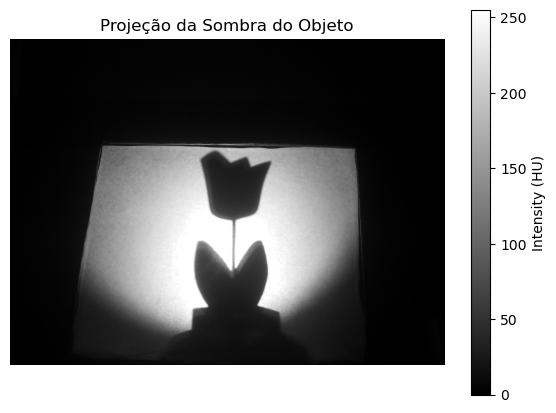

Size: (2592, 1944)
Tipo de imagem: <class 'PIL.Image.Image'>
Tom de cinza mínimo: 0
Tom de cinza máximo: 255



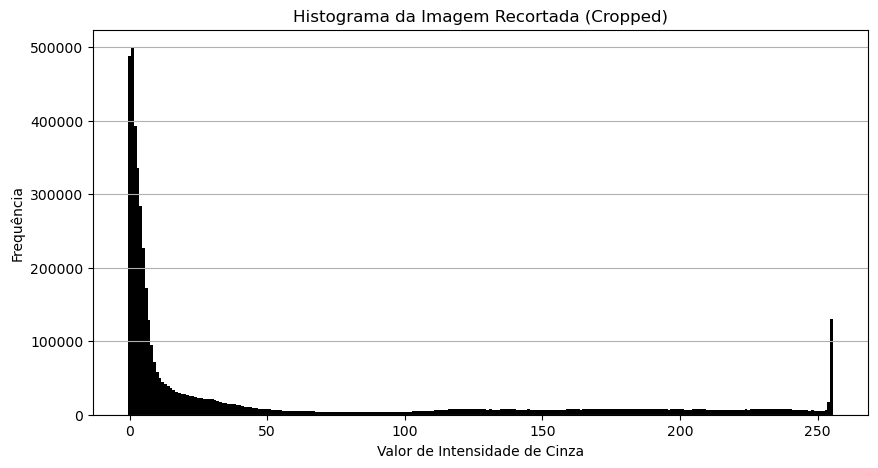

In [42]:
#Image Import
img = images_dict[keys[0]]

#Plot
plot(img, "Projeção da Sombra do Objeto", True);

In [41]:
#Crop

crop_img = crop_image(img)

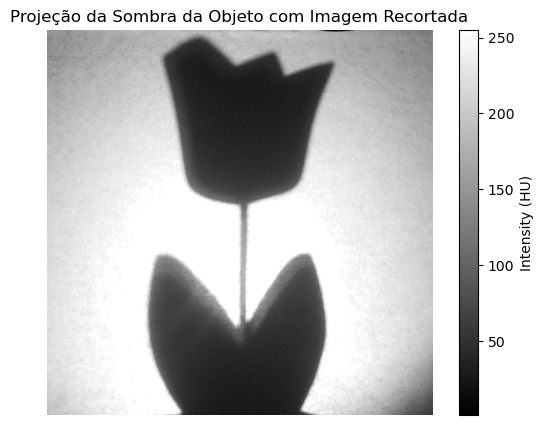

Size: (950, 950)
Tipo de imagem: <class 'PIL.Image.Image'>
Tom de cinza mínimo: 1
Tom de cinza máximo: 255



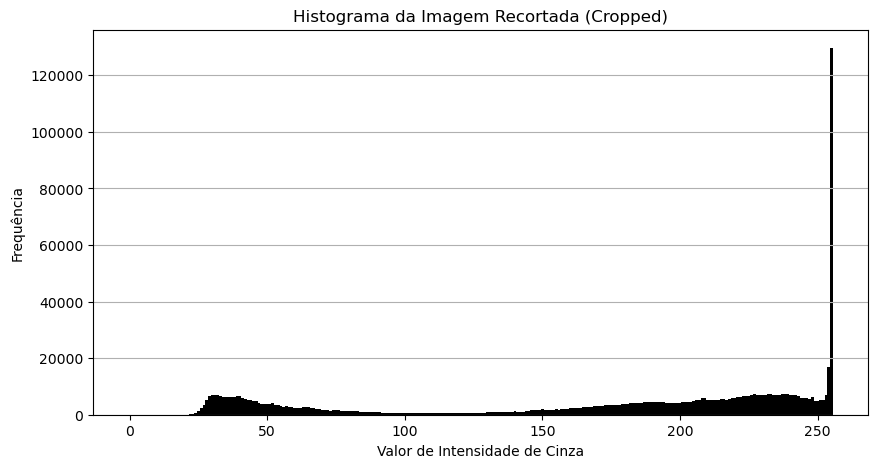

In [43]:
pixels = plot(crop_image(img), "Projeção da Sombra da Objeto com Imagem Recortada",True)

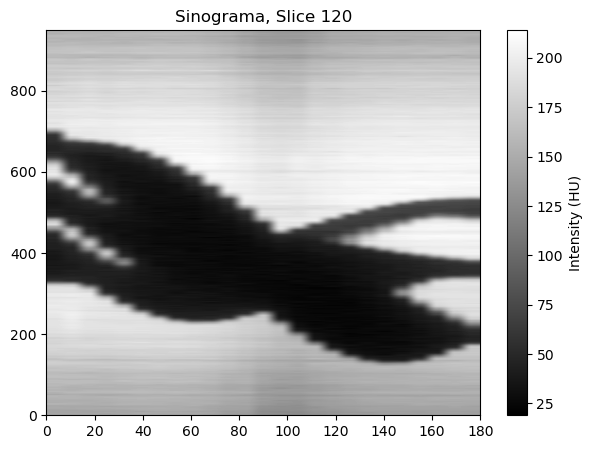

sinogram.shape = (950, 25)


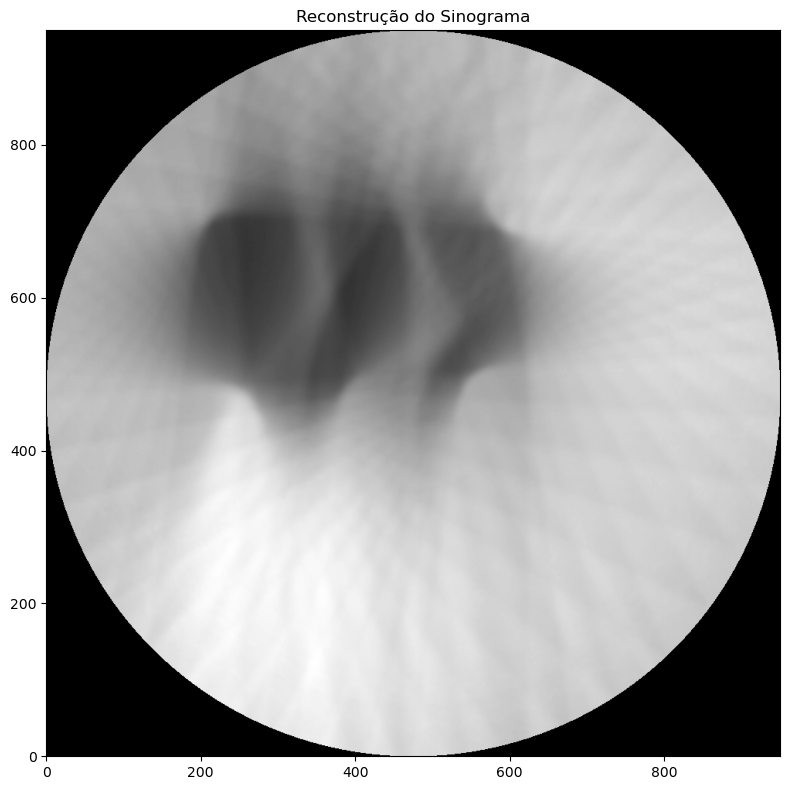

segment.shape = (950, 950)

We have 25 angle values.

First five values of theta:
[ 0.   7.2 14.4 21.6 28.8]

Last five values of theta:
[144.  151.2 158.4 165.6 172.8]


In [34]:
n = 120
segment = create_segment(n, data3d,True);

COMPLEMENTARY CODE

In [44]:
def LUT(img,threshold,max_gray,plot_LUT):

    LUT = np.zeros((max_gray+1,), dtype=int)

    #Thresholds
    LUT[0:threshold] = 1
    LUT[threshold+1:255] = 0

    gray_array = np.array(img)

    mask = np.zeros((img.size[0],img.size[1]), dtype=int)

    for i in range(img.size[0]):
        for j in range(img.size[1]):
            mask[i,j] = LUT[gray_array[i,j]] 
    if plot_LUT == True: 

        a = np.arange(0,256)

        plt.figure(figsize=(14,5)) # Define figure size - default size is quite small.

        plt.subplot(1,2,1) #PLOT LUT
        plt.plot(a, LUT)
        plt.title("LUT Curve")

        plt.subplot(1,2,2) #PLOT LUT PIG image
        plt.imshow(mask, cmap='gray') # cmap is used to choose the colormap
        plt.title("Mask") # Title of the image
        plt.colorbar(label='Intensity (HU)') # Display a colorbar with label
        plt.axis("off") # Turn off the axis ticks and labels
        plt.show()

        print(f'Size: {mask.shape}')
        print(f'Tipo de imagem: {type(mask)}')
        print(f'Tom de cinza mínimo: {mask.min()}')
        print(f'Tom de cinza máximo: {mask.max()}')
    
    return mask

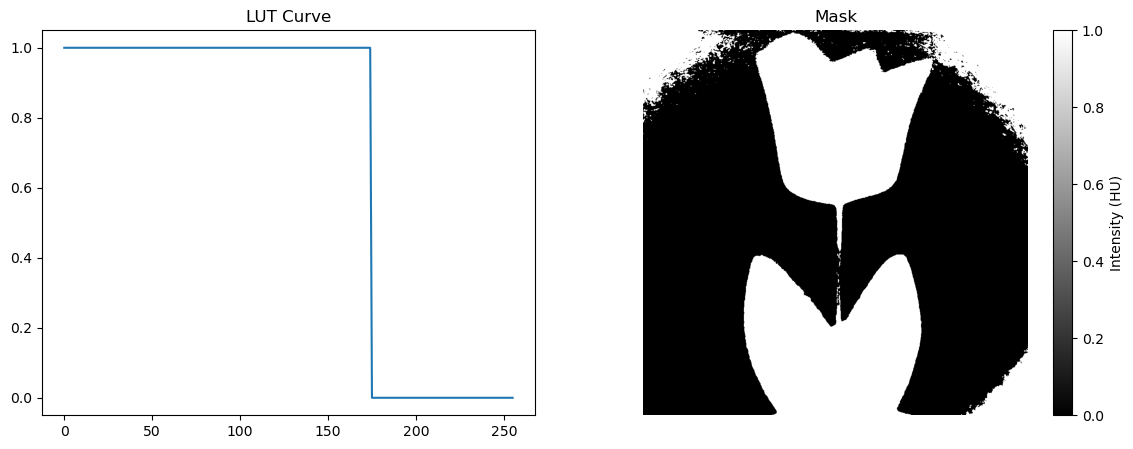

Size: (950, 950)
Tipo de imagem: <class 'numpy.ndarray'>
Tom de cinza mínimo: 0
Tom de cinza máximo: 1


In [45]:
mask = LUT(crop_img, 175, 255,True)

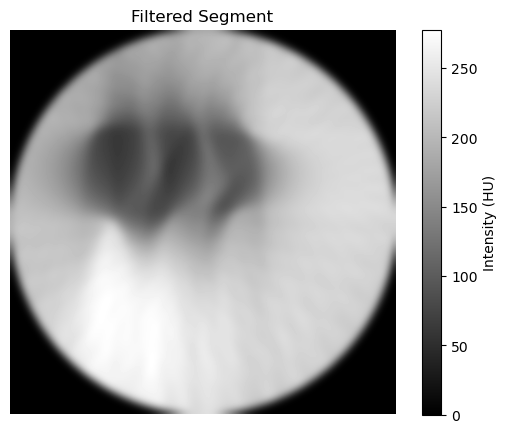

Size: (950, 950)
Tipo de imagem: <class 'numpy.ndarray'>
Tom de cinza mínimo: 0.0
Tom de cinza máximo: 277.65124324805555


In [46]:
#Analise com Filtro Passa Baixa
from scipy.ndimage import gaussian_filter

sigma = 10  # Desvio padrão para o filtro gaussiano
filtered_seg = gaussian_filter(segment, sigma=sigma)
plot(filtered_seg,"Filtered Segment",False);